In [ ]:
!pip install malaya
!pip install PySastrawi
!pip install -U -q PyDrive
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import io, re, random, string, nltk, malaya, pickle
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')

#Machine Learning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

#Deep Learning
import tensorflow as tf
from keras import layers
from keras.models import Sequential
from tensorflow.keras.layers import LSTM, MaxPool1D, Dropout, Dense, GlobalMaxPooling1D, Embedding, Activation
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
from keras import backend as K

#Connect to Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

     |████████████████████████████████| 2.2MB 12.9MB/s 
     |████████████████████████████████| 286kB 54.2MB/s 
     |████████████████████████████████| 71kB 7.9MB/s 
     |████████████████████████████████| 245kB 48.3MB/s 
     |████████████████████████████████| 1.2MB 55.0MB/s 
  Created wheel for ftfy: filename=ftfy-6.0.3-cp37-none-any.whl size=41935 sha256=26becf5e1211cfad33bb58f9e9d5291c866cccb35af23cdb548944ce5dc1aeeb
  Stored in directory: /root/.cache/pip/wheels/99/2c/e6/109c8a28fef7a443f67ba58df21fe1d0067ac3322e75e6b0b7
Successfully built ftfy
     |████████████████████████████████| 215kB 14.2MB/s 


/usr/local/lib/python3.7/dist-packages/malaya_boilerplate/frozen_graph.py:28: UserWarning: Cannot import beam_search_ops from Tensorflow Addons, `deep_model` for stemmer will not available to use, make sure Tensorflow Addons version >= 0.12.0
  'Cannot import beam_search_ops from Tensorflow Addons, `deep_model` for stemmer will not available to use, make sure Tensorflow Addons version >= 0.12.0'


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
Mounted at /content/gdrive


In [ ]:
dataset = pd.read_csv("/content/gdrive/My Drive/Datasets/Code-switching Cyberbullying Detection System/dataset.csv")
dataset.head()

,message,score
0,", melainkan dia tidak tahu, atau cuba meletakk...",0
1,xenophobe russian di sini tidak pernah berhent...,0
2,anda adalah anjing bodoh yang tidak berguna! S...,1
3,kini saya memahami . saya fikir merangsang van...,0
4,"untuk memberi ulasan berat sebelah yang wajar,...",0


In [ ]:
# Convert all messages to lower case
dataset['message'] = dataset['message'].str.lower()

# Replace email addresses with 'email'
dataset['message'] = dataset['message'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$',
                                 'emailaddress')

# Replace URLs with 'webaddress'
dataset['message'] = dataset['message'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$',
                                  'webaddress')

# Replace money symbols with 'moneysymb' (£ can by typed with ALT key + 156)
dataset['message'] = dataset['message'].str.replace(r'£|\$', 'dollers')
    
# Replace 10 digit phone numbers (formats include paranthesis, spaces, no spaces, dashes) with 'phonenumber'
dataset['message'] = dataset['message'].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$',
                                  'phonenumber')

    
# Replace numbers with 'number'
dataset['message'] = dataset['message'].str.replace(r'\d+(\.\d+)?', 'number')

# Remove other symbols
dataset['message'] = dataset['message'].apply(lambda x: ' '.join(
    term for term in x.split() if term not in string.punctuation))

In [ ]:
stop_words = set(stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure'])
dataset['message'] = dataset['message'].apply(lambda x: ' '.join(
    term for term in x.split() if term not in stop_words))

lem=WordNetLemmatizer()
dataset['message'] = dataset['message'].apply(lambda x: ' '.join(
 lem.lemmatize(t, 'v') for t in x.split()))

In [ ]:
sastrawi = malaya.stem.sastrawi()
dataset['message'] = dataset['message'].apply(lambda x: ' '.join(
 sastrawi.stem(t) for t in x.split()))

stopwords_ms = pd.read_csv("/content/gdrive/My Drive/Datasets/Code-switching Cyberbullying Detection System/stopwords-ms.csv")
stopwords_ms = stopwords_ms["words"].values.tolist() + ["anda", "awak", "benar", "kamu"]

dataset['message'] = dataset['message'].apply(lambda x: ' '.join(
    term for term in x.split() if term not in stopwords_ms))

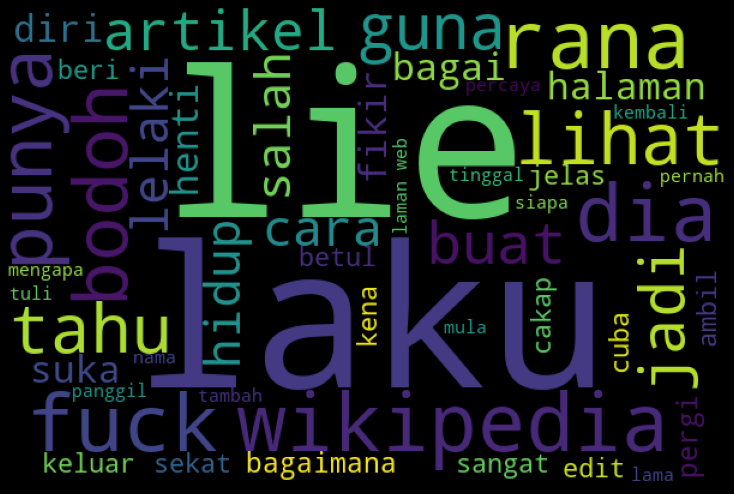

In [ ]:
from wordcloud import WordCloud
hams = dataset['message'][dataset['score']==1]
spam_cloud = WordCloud(width=600,height=400,background_color='black',max_words=50).generate(' '.join(hams))
plt.figure(figsize=(10,8),facecolor='k')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


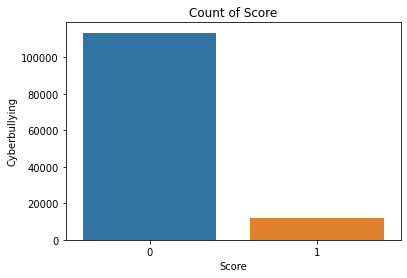

In [ ]:
sns.countplot(dataset['score'])

# Add labels
plt.title('Count of Score')
plt.xlabel('Score')
plt.ylabel('Cyberbullying')
plt.show()

In [ ]:
X = dataset['message']
y = dataset['score']
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=56,test_size=.2)

In [ ]:
def sample_together(n, X, y):
    rows = random.sample(np.arange(0,len(X.index)).tolist(),n)
    return X.iloc[rows,], y.iloc[rows,]

def undersample(X, y, under = 0):
    y_min = y[y == 1]
    y_max = y[y == 0]
    X_min = X.filter(y_min.index,axis = 0)
    X_max = X.filter(y_max.index,axis = 0)

    X_under, y_under = sample_together(len(y_min.index), X_max, y_max)
    
    X = pd.concat([X_under, X_min])
    y = pd.concat([y_under, y_min])
    return X, y

X_train, y_train = undersample(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


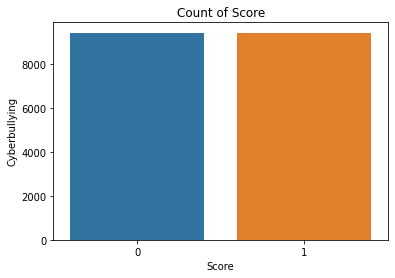

In [ ]:
sns.countplot(y_train)

# Add labels
plt.title('Count of Score')
plt.xlabel('Score')
plt.ylabel('Cyberbullying')
plt.show()

In [ ]:
tf_vec = TfidfVectorizer(max_features = 5000)
X_train = tf_vec.fit_transform(X_train)
X_test = tf_vec.transform(X_test)

In [ ]:
# LogisticRegression
lg = LogisticRegression(C=1, max_iter = 3000, random_state=42)

lg.fit(X_train, y_train)

y_pred_train = lg.predict(X_train)
print('Training accuracy is {}'.format(accuracy_score(y_train, y_pred_train)))
y_pred_test = lg.predict(X_test)
print('Test accuracy is {}'.format(accuracy_score(y_test,y_pred_test)))
print(confusion_matrix(y_test,y_pred_test))
print(classification_report(y_test,y_pred_test))

Training accuracy is 0.8929252277059945
Test accuracy is 0.8799122282066627
[[20122  2637]
 [  373  1933]]
              precision    recall  f1-score   support

           0       0.98      0.88      0.93     22759
           1       0.42      0.84      0.56      2306

    accuracy                           0.88     25065
   macro avg       0.70      0.86      0.75     25065
weighted avg       0.93      0.88      0.90     25065



In [ ]:
lol = tf_vec.transform(["what a bro, im glad met you"])
lg.predict(lol)

array([1])

In [ ]:
dt = DecisionTreeClassifier(max_depth=1000)

dt.fit(X_train, y_train)
y_pred_train = dt.predict(X_train)
print('Training accuracy is {}'.format(accuracy_score(y_train, y_pred_train)))
y_pred_test = dt.predict(X_test)
print('Test accuracy is {}'.format(accuracy_score(y_test,y_pred_test)))
print(confusion_matrix(y_test,y_pred_test))
print(classification_report(y_test,y_pred_test))

Training accuracy is 0.9966108875238296
Test accuracy is 0.7735487731897067
[[17637  5122]
 [  554  1752]]
              precision    recall  f1-score   support

           0       0.97      0.77      0.86     22759
           1       0.25      0.76      0.38      2306

    accuracy                           0.77     25065
   macro avg       0.61      0.77      0.62     25065
weighted avg       0.90      0.77      0.82     25065



In [ ]:
rf = RandomForestClassifier(max_depth = 1000)

rf.fit(X_train, y_train)
y_pred_train = rf.predict(X_train)
print('Training accuracy is {}'.format(accuracy_score(y_train, y_pred_train)))
y_pred_test = rf.predict(X_test)
print('Test accuracy is {}'.format(accuracy_score(y_test,y_pred_test)))
print(confusion_matrix(y_test,y_pred_test))
print(classification_report(y_test,y_pred_test))

Training accuracy is 0.9966108875238296
Test accuracy is 0.8825453820067823
[[20332  2427]
 [  517  1789]]
              precision    recall  f1-score   support

           0       0.98      0.89      0.93     22759
           1       0.42      0.78      0.55      2306

    accuracy                           0.88     25065
   macro avg       0.70      0.83      0.74     25065
weighted avg       0.92      0.88      0.90     25065



In [ ]:
ada=AdaBoostClassifier(n_estimators=100)
ada.fit(X_train, y_train)
y_pred_train = ada.predict(X_train)
print('Training accuracy is {}'.format(accuracy_score(y_train, y_pred_train)))
y_pred_test = ada.predict(X_test)
print('Test accuracy is {}'.format(accuracy_score(y_test,y_pred_test)))
print(confusion_matrix(y_test,y_pred_test))
print(classification_report(y_test,y_pred_test))

Training accuracy is 0.8293793687778013
Test accuracy is 0.8802712946339517
[[20332  2427]
 [  574  1732]]
              precision    recall  f1-score   support

           0       0.97      0.89      0.93     22759
           1       0.42      0.75      0.54      2306

    accuracy                           0.88     25065
   macro avg       0.69      0.82      0.73     25065
weighted avg       0.92      0.88      0.89     25065



In [ ]:
mnb = MultinomialNB(alpha=0.5)
mnb.fit(X_train, y_train)
y_pred_train = mnb.predict(X_train)
print('Training accuracy is {}'.format(accuracy_score(y_train, y_pred_train)))
y_pred_test = mnb.predict(X_test)
print('Test accuracy is {}'.format(accuracy_score(y_test,y_pred_test)))
print(confusion_matrix(y_test,y_pred_test))
print(classification_report(y_test,y_pred_test))

Training accuracy is 0.8752912518534209
Test accuracy is 0.8578096947935369
[[19557  3202]
 [  362  1944]]
              precision    recall  f1-score   support

           0       0.98      0.86      0.92     22759
           1       0.38      0.84      0.52      2306

    accuracy                           0.86     25065
   macro avg       0.68      0.85      0.72     25065
weighted avg       0.93      0.86      0.88     25065



In [ ]:
# saving
with open('tf_vec.pkl', 'wb') as handle:
    pickle.dump(tf_vec, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('model.pkl', 'wb') as handle:
    pickle.dump(lg, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
max_words = 5000
max_len = 200

X = dataset['message']
y = dataset['score']
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=56,test_size=.2)
X_train, y_train = undersample(X_train, y_train)

# Fit/Train tokenizer based on train dataset
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
sequences = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(sequences, maxlen=max_len)

# Transform X_test based on fitted tokenizer
sequences = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(sequences, maxlen=max_len)

In [ ]:
X_train.shape

(18884, 280)

In [ ]:
y_train.shape

(18884,)

In [ ]:
model = Sequential()
model.add(layers.Embedding(max_words, 256))
model.add(layers.LSTM(128,dropout=0.5))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.8))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dropout(0.8))
model.add(layers.Dense(1,activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Recall() , tf.keras.metrics.Precision()])
checkpoint = ModelCheckpoint("model.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test),callbacks=[checkpoint])

Epoch 1/10
591/591 [==============================] - 242s 379ms/step - loss: 0.6767 - accuracy: 0.5506 - recall: 0.6992 - precision: 0.5232 - val_loss: 0.4032 - val_accuracy: 0.8615 - val_recall: 0.8332 - val_precision: 0.5314

Epoch 00001: val_accuracy improved from -inf to 0.86152, saving model to model.hdf5
Epoch 2/10
591/591 [==============================] - 227s 384ms/step - loss: 0.6072 - accuracy: 0.6629 - recall: 0.8420 - precision: 0.5260 - val_loss: 0.4271 - val_accuracy: 0.8278 - val_recall: 0.8674 - val_precision: 0.5364

Epoch 00002: val_accuracy did not improve from 0.86152
Epoch 3/10
591/591 [==============================] - 226s 382ms/step - loss: 0.5689 - accuracy: 0.6960 - recall: 0.8726 - precision: 0.5292 - val_loss: 0.5240 - val_accuracy: 0.7174 - val_recall: 0.8881 - val_precision: 0.5258

Epoch 00003: val_accuracy did not improve from 0.86152
Epoch 4/10
591/591 [==============================] - 227s 385ms/step - loss: 0.5548 - accuracy: 0.7122 - recall: 0.892

In [ ]:
y_pred = model.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = []
for item in y_pred:
  if item[0] > 0.5:
    y_pred_bool.append(1)
  else:
    y_pred_bool.append(0)
print(confusion_matrix(y_test, rofl))
print(classification_report(y_test, rofl))

392/392 [==============================] - 50s 129ms/step
[[18089  4670]
 [  249  2057]]
              precision    recall  f1-score   support

           0       0.99      0.79      0.88     22759
           1       0.31      0.89      0.46      2306

    accuracy                           0.80     25065
   macro avg       0.65      0.84      0.67     25065
weighted avg       0.92      0.80      0.84     25065



In [ ]:
# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
model.save("model.h5")